# Structured data

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [13]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *

PATH='data/stock/'

## Create datasets

You can download the datasets used [here](https://www.kaggle.com/c/titanic/data).

Feature Space:
* train: Training set provided by competition
* test: testing set

In [14]:
table_names = ['btc-bitstamp-2012-01-01_to_2018-01-08']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [15]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [16]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains Passenger info such as Gender, Age, Ticket, Fare and whether Survived, the prediction variable
* test: Same as training table, w/o Survived


In [17]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


The following returns summarized aggregate information to each table accross each field.

In [18]:
for t in tables: display(DataFrameSummary(t).summary())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.16106e+06,3.16106e+06,3.16106e+06,3.16106e+06,3.16106e+06,3.16106e+06,3.16106e+06,3.16106e+06
mean,1.42034e+09,963.8,964.655,962.787,963.793,11.1296,9835.7,963.717
std,5.49194e+07,2260.8,2263.64,2257.31,2260.79,35.9115,53319.3,2260.51
min,1.32532e+09,3.8,3.8,1.5,1.5,0,0,3.8
25%,1.37273e+09,110.99,111,110.92,110.99,0.446709,66.3664,110.982
50%,1.42015e+09,378.67,378.88,378.39,378.66,2.07566,365.32,378.645
75%,1.46795e+09,658.39,659,657.86,658.44,8.83241,2660.46,658.42
max,1.51537e+09,19665.8,19666,19650,19665.8,5853.85,5.14793e+06,19663.3
counts,3161057,3161057,3161057,3161057,3161057,3161057,3161057,3161057
uniques,3161057,322563,302500,318358,317580,1576051,1912214,1425521


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [19]:
train= tables[0]

In [20]:
len(train)

3161057

Time modifications

In [21]:
#convert to date objects
train["Timestamp"] = pd.to_datetime(train["Timestamp"], unit='s')
train['hour'] = train.Timestamp.dt.hour;
train['minute'] = train.Timestamp.dt.minute;
train.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,hour,minute
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,52
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,53
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,54
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,55
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,56


SET DEPENDENT VARIABLE ACTION

In [22]:
lookahead = 15
train['action'] =  train['Close'].rolling(window=lookahead).max() > train['Close']
train.action = train.action.astype(int)
train.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,hour,minute,action
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,52,0
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,53,0
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,54,0
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,55,0
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,56,0


In [23]:
# edit columns

train["VolumeBTC"] = train["Volume_(BTC)"]
train.drop('Volume_(BTC)',1,inplace=True)
train["VolumeCurrency"] = train["Volume_(Currency)"]
train.drop('Volume_(Currency)',1,inplace=True)
train["WeightedPrice"] = train["Weighted_Price"]
train.drop('Weighted_Price',1,inplace=True)

# delete unused columns
train.drop('VolumeCurrency',1,inplace=True)
train.head()

,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,WeightedPrice
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,7,52,0,0.455581,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,7,53,0,0.455581,4.39
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,7,54,0,0.455581,4.39
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,7,55,0,0.455581,4.39
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,7,56,0,0.455581,4.39


In [24]:
# trim to a million records for now
# TODO: remove this
train = train[-500000:]
train.reset_index(inplace=True)

In [25]:
# remove all 0 values 
train = train[train.Open!=0]
train = train[train.High!=0]
train = train[train.Low!=0]
train = train[train.Close!=0]
train = train[train.WeightedPrice!=0]

In [26]:
# add technical analysis
# train = add_all_ta_features(train, "Open", "High", "Low", "Close", "VolumeBTC", fillna=False)

In [27]:
# add all date time values
add_datepart(train, "Timestamp", drop=False)

In [28]:
train.to_feather(f'{PATH}train')

In [29]:
train = pd.read_feather(f'{PATH}train')

In [30]:
train

,index,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,...,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed
0,2661057,2017-01-25 18:41:00,894.32,894.32,894.18,894.32,18,41,0,0.156743,...,25,2,25,False,False,False,False,False,False,1485369660
1,2661058,2017-01-25 18:42:00,894.16,894.32,894.11,894.11,18,42,1,8.811636,...,25,2,25,False,False,False,False,False,False,1485369720
2,2661059,2017-01-25 18:43:00,894.02,894.02,894.02,894.02,18,43,1,0.055000,...,25,2,25,False,False,False,False,False,False,1485369780
3,2661060,2017-01-25 18:44:00,893.30,894.01,893.02,894.00,18,44,1,7.489003,...,25,2,25,False,False,False,False,False,False,1485369840
4,2661061,2017-01-25 18:45:00,893.30,894.01,893.30,894.01,18,45,1,0.020000,...,25,2,25,False,False,False,False,False,False,1485369900
5,2661062,2017-01-25 18:46:00,893.70,893.72,893.70,893.72,18,46,1,0.938427,...,25,2,25,False,False,False,False,False,False,1485369960
6,2661063,2017-01-25 18:47:00,894.02,894.31,894.02,894.31,18,47,1,0.068000,...,25,2,25,False,False,False,False,False,False,1485370020
7,2661064,2017-01-25 18:48:00,894.31,894.31,894.31,894.31,18,48,1,0.119814,...,25,2,25,False,False,False,False,False,False,1485370080
8,2661065,2017-01-25 18:49:00,894.31,894.32,894.31,894.32,18,49,0,0.320000,...,25,2,25,False,False,False,False,False,False,1485370140
9,2661066,2017-01-25 18:50:00,894.32,894.32,894.06,894.06,18,50,1,0.306016,...,25,2,25,False,False,False,False,False,False,1485370200


We fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

## Create features

In [31]:
train.head(30).T.head(70)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
index,2661057,2661058,2661059,2661060,2661061,2661062,2661063,2661064,2661065,2661066,...,2661077,2661078,2661079,2661080,2661081,2661082,2661083,2661084,2661085,2661086
Timestamp,2017-01-25 18:41:00,2017-01-25 18:42:00,2017-01-25 18:43:00,2017-01-25 18:44:00,2017-01-25 18:45:00,2017-01-25 18:46:00,2017-01-25 18:47:00,2017-01-25 18:48:00,2017-01-25 18:49:00,2017-01-25 18:50:00,...,2017-01-25 19:01:00,2017-01-25 19:02:00,2017-01-25 19:03:00,2017-01-25 19:04:00,2017-01-25 19:05:00,2017-01-25 19:06:00,2017-01-25 19:07:00,2017-01-25 19:08:00,2017-01-25 19:09:00,2017-01-25 19:10:00
Open,894.32,894.16,894.02,893.3,893.3,893.7,894.02,894.31,894.31,894.32,...,894.65,894.65,894.59,894.71,894.61,894.7,893.66,893.48,893.48,894.09
High,894.32,894.32,894.02,894.01,894.01,893.72,894.31,894.31,894.32,894.32,...,894.65,894.65,894.59,894.71,894.7,894.7,894.69,893.54,893.48,894.27
Low,894.18,894.11,894.02,893.02,893.3,893.7,894.02,894.31,894.31,894.06,...,894.65,894.65,894.59,894.61,894.61,894.02,893.45,893.48,893.48,894.09
Close,894.32,894.11,894.02,894,894.01,893.72,894.31,894.31,894.32,894.06,...,894.65,894.65,894.59,894.61,894.7,894.02,894.22,893.48,893.48,894.27
hour,18,18,18,18,18,18,18,18,18,18,...,19,19,19,19,19,19,19,19,19,19
minute,41,42,43,44,45,46,47,48,49,50,...,1,2,3,4,5,6,7,8,9,10
action,0,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
VolumeBTC,0.156743,8.81164,0.055,7.489,0.02,0.938427,0.068,0.119814,0.32,0.306016,...,0.080603,0.080603,0.0240823,1.12373,0.460575,3.01714,1.31507,2.90421,0.69446,0.214884


In [32]:
display(DataFrameSummary(train).summary())

,index,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,...,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed
count,500000,NaN,500000,500000,500000,500000,500000,500000,500000,500000,...,500000,500000,500000,NaN,NaN,NaN,NaN,NaN,NaN,500000
mean,2.91106e+06,NaN,4391.32,4395.73,4385.99,4391.28,11.5059,29.5007,0.81808,9.16259,...,15.686,3.01664,191.53,NaN,NaN,NaN,NaN,NaN,NaN,1.50037e+09
std,144338,NaN,4242.05,4248.14,4234.49,4242.04,6.92411,17.3183,0.385779,20.3888,...,8.94219,1.99802,100.872,NaN,NaN,NaN,NaN,NaN,NaN,8.66026e+06
min,2.66106e+06,NaN,891.99,892.56,891.33,891.33,0,0,0,0,...,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1.48537e+09
25%,2.78606e+06,NaN,1266.46,1267.12,1266.05,1266.55,6,15,1,0.590944,...,8,1,105,NaN,NaN,NaN,NaN,NaN,NaN,1.49287e+09
50%,2.91106e+06,NaN,2718.04,2719.96,2716,2718.13,12,30,1,3.00434,...,16,3,192,NaN,NaN,NaN,NaN,NaN,NaN,1.50037e+09
75%,3.03606e+06,NaN,5328.44,5332,5323.87,5328.47,18,45,1,9.845,...,24,5,279,NaN,NaN,NaN,NaN,NaN,NaN,1.50787e+09
max,3.16106e+06,NaN,19665.8,19666,19650,19665.8,23,59,1,1616.06,...,31,6,365,NaN,NaN,NaN,NaN,NaN,NaN,1.51537e+09
counts,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,...,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
uniques,500000,500000,235187,216139,231505,230927,24,60,2,439163,...,31,7,349,2,2,2,2,2,2,500000


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [33]:
train.head()

,index,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,...,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed
0,2661057,2017-01-25 18:41:00,894.32,894.32,894.18,894.32,18,41,0,0.156743,...,25,2,25,False,False,False,False,False,False,1485369660
1,2661058,2017-01-25 18:42:00,894.16,894.32,894.11,894.11,18,42,1,8.811636,...,25,2,25,False,False,False,False,False,False,1485369720
2,2661059,2017-01-25 18:43:00,894.02,894.02,894.02,894.02,18,43,1,0.055000,...,25,2,25,False,False,False,False,False,False,1485369780
3,2661060,2017-01-25 18:44:00,893.30,894.01,893.02,894.00,18,44,1,7.489003,...,25,2,25,False,False,False,False,False,False,1485369840
4,2661061,2017-01-25 18:45:00,893.30,894.01,893.30,894.01,18,45,1,0.020000,...,25,2,25,False,False,False,False,False,False,1485369900


Identify categorical vs continuous variables.  PassengerId serves as the unique identifier for each row.

In [34]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek', 'TimestampDayofyear', 
'TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end', 'TimestampIs_quarter_start', 
'TimestampIs_year_end', 'TimestampIs_year_start', 'TimestampElapsed']

contin_vars = ['Open', 'Close','High', 'Low', 'VolumeBTC', 'WeightedPrice']

index='Timestamp'
dep = 'action'
n = len(train); n
   

500000

In [35]:
train = train[cat_vars+contin_vars+[dep, index]].copy()

In [36]:
# test[dep] = 0
# test = test[cat_vars+contin_vars+[dep, index]].copy()

In [37]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [38]:
# TODO: need to add this back
# apply_cats(test, train)

In [39]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
#     test[v] = test[v].astype('float32')

In [40]:
samp_size = n
train_samp = train.set_index(index)
n

500000

We can now process our data...

In [41]:
train_samp.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,...,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,Open,Close,High,Low,VolumeBTC,WeightedPrice,action
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-25 18:41:00,2017,1,4,25,18,41,2,25,False,False,...,False,False,1485369660,894.320007,894.320007,894.320007,894.179993,0.156743,894.283386,0
2017-01-25 18:42:00,2017,1,4,25,18,42,2,25,False,False,...,False,False,1485369720,894.159973,894.109985,894.320007,894.109985,8.811636,894.259583,1


In [42]:
df, y, nas, mapper = proc_df(train_samp, dep, do_scale=True)

In [43]:
y.shape


(500000,)

In [44]:
# df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, 
#                                   mapper=mapper, na_dict=nas)

For some reason, nas were found for Fare_log when there was not an NA value and it caused the code to fail downstream.  Here I inspected the value and then just removed the column :)

In [45]:
nas
# df_test.Fare_log_na.unique()
# df_test.loc[df_test.Fare_log_na!=True]

{}

In [46]:
nas={}

In [47]:
# df_test = df_test.drop(['Fare_log_na'], axis=1)

In [48]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,...,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,Open,Close,High,Low,VolumeBTC,WeightedPrice
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-25 18:41:00,1,1,3,25,19,42,3,9,1,1,...,1,1,1,1,-0.824367,-0.824358,-0.824225,-0.824613,-0.441705,-0.824387
2017-01-25 18:42:00,1,1,3,25,19,43,3,9,1,1,...,1,1,1,2,-0.824405,-0.824407,-0.824225,-0.824630,-0.017213,-0.824392


In [49]:
# df_test.head(2)

Rake the last x% of rows as our validation set.

In [50]:
train_ratio = 0.99
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [51]:
len(val_idx)

5000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set False because there is only one predicted label (Survived) per row (of type int).  

In [52]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False)
# ,test_df=df_test

Some categorical variables have a lot more levels than others.

In [53]:
cat_sz = [(c, len(train_samp[c].cat.categories)+1) for c in cat_vars]

In [54]:
cat_sz

[('TimestampYear', 3),
 ('TimestampMonth', 13),
 ('TimestampWeek', 52),
 ('TimestampDay', 32),
 ('hour', 25),
 ('minute', 61),
 ('TimestampDayofweek', 8),
 ('TimestampDayofyear', 350),
 ('TimestampIs_month_end', 3),
 ('TimestampIs_month_start', 3),
 ('TimestampIs_quarter_end', 3),
 ('TimestampIs_quarter_start', 3),
 ('TimestampIs_year_end', 3),
 ('TimestampIs_year_start', 3),
 ('TimestampElapsed', 500001)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [55]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [56]:
emb_szs

[(3, 2),
 (13, 7),
 (52, 26),
 (32, 16),
 (25, 13),
 (61, 31),
 (8, 4),
 (350, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (500001, 50)]

Check if cude is available

In [57]:
torch.cuda.is_available()

True

In [58]:
len(df.columns)-len(cat_vars)

6

In [59]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.06, 2, [100,50], [0.03,0.06],None,True)

In [60]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(13, 7)
    (2): Embedding(52, 26)
    (3): Embedding(32, 16)
    (4): Embedding(25, 13)
    (5): Embedding(61, 31)
    (6): Embedding(8, 4)
    (7): Embedding(350, 50)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(500001, 50)
  )
  (lins): ModuleList(
    (0): Linear(in_features=217, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True)
)

 78%|███████▊  | 6011/7735 [02:23<00:41, 41.96it/s, loss=1.41] 

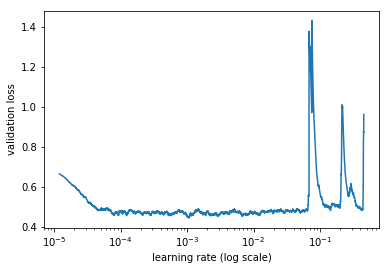

In [61]:
m.lr_find()
m.sched.plot(100)
lr = 1e-5

In [62]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                 
    0      0.469998   0.43102   
    1      0.469394   0.42914                                  
    2      0.471948   0.427748                                 


[array([0.42775])]

In [63]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.465389   0.427358  
    1      0.465639   0.427038                                 
    2      0.458246   0.426757                                 
    3      0.453515   0.426513                                 
    4      0.460675   0.426483                                 


[array([0.42648])]

In [64]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                 
    0      0.465295   0.42633   
    1      0.436208   0.427016                                 
    2      0.435083   0.427402                                 
    3      0.438883   0.427505                                 
    4      0.425807   0.428975                                 
    5      0.381915   0.435943                                 
    6      0.36185    0.443754                                 
    7      0.327077   0.453148                                 
    8      0.31385    0.460796                                 
    9      0.310296   0.465941                                 
    10     0.286877   0.46808                                  
    11     0.296396   0.468402                                 
    12     0.284271   0.489677                                 
    13     0.252977   0.513712                                 
    14     0.230479   0.540375                                 
    15 

[array([0.71784])]

In [65]:
m.save('btcBinaryClassificationModel')

In [66]:
m.load('btcBinaryClassificationModel')

## Validation

In [67]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [68]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..., 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0]),
 array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

In [69]:
y1.shape


(5000,)

In [70]:
val = train.iloc[val_idx]
val[[index,dep]]
valpred = pd.DataFrame({'Close':val.Close,'Timestamp':val.Timestamp, 'action':val.action, 'predicted':np.argmax(x,axis=1)})[['Close','Timestamp', 'action','predicted']]
valpred.head(100)

,Close,Timestamp,action,predicted
495000,14329.980469,2018-01-04 12:41:00,1,1
495001,14327.540039,2018-01-04 12:42:00,1,1
495002,14289.019531,2018-01-04 12:43:00,1,1
495003,14266.530273,2018-01-04 12:44:00,1,1
495004,14273.639648,2018-01-04 12:45:00,1,0
495005,14348.459961,2018-01-04 12:46:00,1,0
495006,14445.700195,2018-01-04 12:47:00,0,1
495007,14434.290039,2018-01-04 12:48:00,1,1
495008,14431.540039,2018-01-04 12:49:00,1,1
495009,14446.290039,2018-01-04 12:50:00,0,1


Calculate the percent accuracy

In [71]:
predicted = valpred.loc[valpred.action == valpred.predicted]
accuracy = len(predicted)/len(val)
accuracy

0.7032

## Test and Kaggle Submission

In [72]:
# np.argmax(m.predict(True), axis =1)

In [73]:
# sub = pd.DataFrame({'Timestamp':test.index, 'action':np.argmax(m.predict(True), axis =1)})[['Timestamp', 'action']]
# sub.head(10)

In [74]:
# csv_fn=f'{PATH}/tmp/sub4.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

## RF

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [77]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

Accuracy of 87% on the validation set using a Random Forest Regressor.

In [78]:
# def PredtoClass(a):
#     pred_class = []
#     for i in range(len(a)):
#         if a[i]<.5:
#             pred_class.append(0)
#         else:
#             pred_class.append(1)
#     return pred_class
# def accuracy(preds, y_val):
#     return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

In [79]:
# preds = m.predict(val)
# m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

In [80]:
# preds_test = m.predict(df_test.values)

In [81]:
# sub = pd.DataFrame({'PassengerId':test.index, 'Survived':PredtoClass(preds_test)})[['PassengerId', 'Survived']]
# sub.head(10)

In [82]:
# csv_fn=f'{PATH}/tmp/RFsub5.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

This random forest submission also received a score of 0.77033, exactly the same as the nn score, despite the 86.7% validation set accuracy.